# Fig 4 - Conservation of uORF repressiveness and sequence features

## Imports, parameters and functions

In [1]:
# FILTER PARAMETERS
UTR5_LENGTH_MIN = 25
UTR3_LENGTH_MIN = 25

FPKM_MIN = 0.01
CDS_LENGTH_MIN = 100
CDS_READS_MIN = 1

UORF_LENGTH_MIN = 20
UORF_FROM_TRANSCRIPT_START_MIN = UTR5_LENGTH_MIN
UORF_READS_MIN = 1

UTR5_READS_MIN = 1

ORF_END_TRIM = 10

In [2]:
# IMPORTS
import corebio
import weblogolib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn.apionly as sns

from Bio import SeqIO
from IPython.display import display, HTML, Markdown, Image
from ast import literal_eval
from numpy import argmax, mean, log10, log2, inf, nan, array, float64, subtract, multiply, divide, sign
from pandas import Panel, DataFrame, Series
from pandas.stats.moments import rolling_mean
from scipy.stats import spearmanr, ks_2samp, pearsonr, linregress, zscore, kendalltau, kde
from scipy.stats.mstats import trimboth
from sklearn.linear_model import Ridge, RidgeCV
from statsmodels.distributions import ECDF
from statsmodels.nonparametric.smoothers_lowess import lowess

%matplotlib inline

In [3]:
pd.options.display.mpl_style = 'default'
pd.options.mode.chained_assignment = None
mpl.rcParams['figure.figsize'] = 8, 6
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.facecolor'] = "#fdfdfd"
mpl.rcParams['grid.alpha'] = 0.5
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['savefig.dpi'] = 50

In [4]:
C_NT = ("#00d700", "#df1f00", "#0226cc", "#ffb700")
C_UORF = ('#b30000', '#e34a33', '#fc8d59', '#fdbb84', '#fdd49e')
C_CDS = ("#105e47", "#157e5f", "#1b9e77", "#48b192", "#76c4ad")
C_RATIO = "#7570b3"
C_BG = ("#000000", "#525252", "#969696", "#d9d9d9")
C_SP = {"hs": "#97543a", "mm": "#546079", "dr": "#3d7463"}
C_SP_BAR = {"hs": "#fc8d62", "mm": "#8da0cb", "dr": "#66c2a5"}
C_NOBIAS = "#ffd92f"
C_SCATTER = "#737373"
C_TREND = "#e41a1c"
C_TLOC = {"5' UTR": "#d95f02", "CDS start": "#1b9e77", "CDS internal": "#e7298a", "3' UTR": "#e6ab02"}
C_STARTS = ("#276419", "#4d9221", "#7fbc41")
C_STOPS = ("#8e0152", "#c51b7d", "#de77ae")

In [5]:
def flatten(i):
    return [j for k in i for j in k]

def clean(i):
    return i.replace([-inf, inf], nan).dropna()

def z(i):
    return (i - i.mean()) / i.std(ddof=0)

In [6]:
def scatter_linear_trend(x, y, x_label, y_label, plot_trend=True, corr_table=True):
    data = DataFrame({"x": x, "y": y}).dropna()
    
    plt.figure()
    plt.scatter(data.x, data.y, alpha=0.25, c=C_SCATTER)

    mod = Ridge(normalize=False).fit(zip(*[data.x,]), data.y)
    x1, x2 = (np.percentile(data.x, 2.5), np.percentile(data.x, 97.5))
    y1, y2 = mod.predict([(x1,), (x2,)])
    
    plt.ylim(np.percentile(data.y, 1), np.percentile(data.y, 99))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if plot_trend:
        plt.plot((x1, x2), (y1, y2), c=C_TREND, lw=2)

    if corr_table:
        to_display = DataFrame(columns=["Correlation\ncoefficient", "p-value"])

        corr, p = pearsonr(data.x, data.y)
        to_display.loc["Pearson linear"] = {"Correlation\ncoefficient": corr,
                                    "p-value": p}
        corr, p = spearmanr(data.x, data.y)
        to_display.loc["Spearman rank"] = {"Correlation\ncoefficient": corr,
                                  "p-value": p}

        display(Markdown(y_label + " against " + x_label))
        display(to_display.applymap('{:,.4g}'.format))
    
    return abs(y2 - y1), sign(y2 - y1)

In [7]:
def conserve_plot_subset_by_num_uORF(ss, pairs, s_limitss, parameters, para_labels, para_is_logs, species_label):
    for s, pair, limitss in zip(ss, pairs, s_limitss):
        s1, s2 = pair["s1"], pair["s2"]
        set_labels = ["all filtered transcripts",
                      "without uORFs",
                      "with 1-2 uORFs",
                      "with 3+ uORFs"]

        set_filters = [Series({i:True for i in s[s1].index}),
                       ((s[s1]["num_uORFs"] == 0) & (s[s2]["num_uORFs"] == 0)),
                       ((s[s1]["num_uORFs"] >= 1) & (s[s2]["num_uORFs"] >= 1) & \
                        (s[s1]["num_uORFs"] <= 2) & (s[s2]["num_uORFs"] <= 2)),
                       ((s[s1]["num_uORFs"] >= 3) & (s[s2]["num_uORFs"] >= 3))]

        set_colors = (C_CDS[2], C_SCATTER, C_UORF[0], C_UORF[3])
        
        conserve_plot(s, pair, parameters, para_labels, limitss, para_is_logs, s1, s2, set_labels, set_filters, set_colors)

In [8]:
def conserve_plot_subset_by_uORF_similarity(ss, pairs, s_limitss, parameters, para_labels, para_is_logs, species_label):
    for s, pair, limitss in zip(ss, pairs, s_limitss):
        s1, s2 = pair["s1"], pair["s2"]
        set_labels = ["all filtered transcripts",
                      "similar number of uORFs", "diff number of uORFs",
                      "if uORFs differs"]

        set_filters = [Series({i:True for i in s[s1].index}),
                       (((s[s1]["num_uORFs"] - s[s2]["num_uORFs"]).map(abs) <= 1) & \
                        (s[s1]["num_uORFs"] > 0) & (s[s2]["num_uORFs"] > 0)),
                       (((s[s1]["num_uORFs"] - s[s2]["num_uORFs"]).map(abs) > 1) & \
                        (s[s1]["num_uORFs"] > 0) & (s[s2]["num_uORFs"] > 0)),
                       ((s[s1]["num_uORFs"] == 0) ^ (s[s2]["num_uORFs"] == 0))]

        set_colors = [C_CDS[2], C_UORF[0], C_UORF[2], C_SCATTER]
        
        conserve_plot(s, pair, parameters, para_labels, limitss, para_is_logs, s1, s2, set_labels, set_filters, set_colors)

In [9]:
def conserve_plot(s, pair, parameters, para_labels, limitss, para_is_logs, s1, s2, set_labels, set_filters, set_colors):

    summary = DataFrame(columns=[set_labels])
    display(Markdown(species_label[s1] + " vs " + species_label[s2]))

    for parameter, para_label, limits, para_is_log in zip(parameters, para_labels, limitss, para_is_logs):
        entry = {i:0 for i in set_labels}
        plt.figure()
        for set_label, set_filter, set_color in zip(set_labels, set_filters, set_colors):
            if para_is_log:
                data = clean(s.minor_xs(parameter)[set_filter].applymap(log10))
            else:
                data = clean(s.minor_xs(parameter)[set_filter])
            if len(data) != 0:
                plt.scatter(data[s1], data[s2], alpha=1, c=set_color, s=10)
                sns.kdeplot(data[s1], data[s2], n_levels=5, linewidths=[0,3,0,0,0], 
                            cmap=None, colors=set_color, alpha=1)
                plt.plot((100, 100), (100, 100), c=set_color, lw=3,
                         label=set_label + " (n=" + str(len(data)) + ")")

                corr, p = pearsonr(data[s1], data[s2])
                append = ""
                if p < 0.05:
                    append += "*"
                if p < 0.01:
                    append += "*"
                if p < 0.001:
                    append += "*"
                entry[set_label] = '{:,.3g}'.format(corr) + append

        summary.loc[para_label] = entry

        if para_is_log:
            legend = plt.legend(title="log10 " + para_label, loc="upper left")
        else:
            legend = plt.legend(title=para_label, loc="upper left")
        plt.setp(legend.get_title(), fontsize=12)
        plt.xlabel(species_label[s1] + " ortholog")
        plt.ylabel(species_label[s2] + " ortholog")
        plt.xlim(*limits[0])
        plt.ylim(*limits[1])
    summary = summary.T
    summary["n"] = Series({set_label: len(s.minor_xs(parameter)[set_filter]) \
                           for set_filter, set_label in zip(set_filters, set_labels)})
    display(summary)
    display(Markdown("\*: p < 0.05; \*\*: p < 0.01; \*\*\*: p < 0.001"))
    print

In [10]:
def ridge_conservation_z(ss, pairs, to_regress, to_regress_label, regressors, regressor_labels, para_is_logs,
                         limits, limits_coeff, uORF_filter=False, color_coeff=False):

    for s, pair in zip(ss, pairs):
        s1, s2 = pair["s1"], pair["s2"]
        if uORF_filter:
            set_filter = (s[s1]["num_uORFs"] > 0) & (s[s2]["num_uORFs"] > 0)
        
        data = DataFrame()
        for parameter, para_is_log in zip([to_regress,] + regressors, para_is_logs):
            if para_is_log:
                df = clean(s.minor_xs(parameter).applymap(float).applymap(log10)).apply(z)
            else:
                df = clean(s.minor_xs(parameter).applymap(float)).apply(z)
            df.columns = [i + "_" + parameter for i in df.columns]
            if uORF_filter:
                data[df.columns] = df[set_filter]
            else:
                data[df.columns] = df

        div = DataFrame()
        for parameter in [to_regress,] + regressors:
            div[parameter] = data[s1 + "_" + parameter] - data[s2 + "_" + parameter]
        div.dropna(inplace=True)

        mod = Ridge(normalize=False).fit(div[regressors], div[to_regress])
        combined_score = np.sum([div[i].multiply(j) for i, j in zip(regressors, mod.coef_)], axis=0)

        n = str(len(combined_score))
        display(Markdown(species_label[s1] + " vs " + species_label[s2] + " (n=" + n + ")"))

        plt.figure()
        plt.scatter(combined_score, div[to_regress], alpha=0.25, c=C_SCATTER)
        plt.xlabel("Combined divergence of sequence features")
        plt.ylabel("Divergence of " + to_regress_label)
        plt.title(species_label[s1] + " vs " + species_label[s2] + " (n=" + n + ")")

        corr, p = map('{:,.4g}'.format, pearsonr(combined_score, div[to_regress]))

        display(Markdown("Correlation: " + corr + "\np = " + p))

        x1, x2 = [np.percentile(combined_score, i) for i in [2.5, 97.5]]
        predicted = mod.predict(div[regressors])
        y1, y2 = [np.percentile(predicted, i) for i in [2.5, 97.5]]
        plt.plot((x1, x2), (y1, y2), c=C_TREND ,lw=2)
        plt.xlim(*limits[0])
        plt.ylim(*limits[1])

        to_display = DataFrame(columns=["Relative contribution"])
        for i, label, j in zip(regressors, regressor_labels, mod.coef_):
            to_display.loc[label] = {"Relative contribution": j}
        to_display.index.name = "Parameter"
        display(to_display.iloc[::-1].applymap('{:,.4g}'.format))

        plt.figure(figsize=(6, 1 + float(len(to_display)) * .3))
        if color_coeff:
            ax = to_display["Relative contribution"].plot(kind="barh", width=0.9, color=color_coeff)
        else:
            ax = to_display["Relative contribution"].plot(kind="barh", width=0.9)
        ax.set_xlabel("Relative contribution to divergence")
        plt.xlim(*limits_coeff)
        plt.title(to_regress_label)

## Reading in orthology data

List of directional pair-wise orthologs were downloaded from Ensembl (build 75).

Attributes used: Species 1 Gene, Species 1 Transcript, Species 2 Gene, Species 1 Canonical Protein, Orthology Type, Orthology Confidence

In [11]:
ANNOTATIONS_DIR = "./annotations/"

In [12]:
species = ("mm", "hs", "dr")
species_label = {"mm": "Mouse", "hs": "Human", "dr": "Zebrafish"}
species_stage = {"mm": "mES", "hs": "Hela", "dr": "Shield"}
stage_species = {"mES": "mm", "HeLa": "hs", "Shield": "dr"}

In [13]:
pairs = [{"s1": "mm", "s2": "hs"},
         {"s1": "mm", "s2": "dr"},
         {"s1": "hs", "s2": "dr"}]

Orthology pairs were filtered for high confidence and one2one orthology. Only gene IDs were compiled (duplicates orginating from a gene having multiple transcripts were dropped).

In [14]:
ortholog_pairs = DataFrame(index=species, columns=species)

for s1, s2 in [(pair["s1"], pair["s2"]) for pair in pairs]:
    ortholog_file = ANNOTATIONS_DIR + s1 + "-" + s2 + "_orthologs.df"
    orthology = DataFrame.from_csv(ortholog_file, sep="\t", index_col=False)
    orthology = orthology[(orthology["orthology_confidence"] == 1) &
                          (orthology["homology_type"] == "ortholog_one2one")]
    
    
    orthology = pd.concat((orthology[s1 + "_Gene"], orthology[s2 + "_Gene"]), axis=1)
    orthology = orthology.drop_duplicates((s1 + "_Gene", s2 + "_Gene"))
    ortholog_pairs[s1][s2] = orthology.set_index(s1 + "_Gene").squeeze()

In [15]:
print "Species, Number of Pairs"
for s1, s2 in [(pair["s1"], pair["s2"]) for pair in pairs]:
    print s1, s2, len(ortholog_pairs[s1][s2])

Species, Number of Pairs
mm hs 9487
mm dr 8240
hs dr 8228


## Reading in ORF characteristics data

Files were read in as DataFrames into a master DataFrame, filtered for presence in the orthology pairs gene sets.

In [16]:
CONVERTERS = {i:literal_eval for i in ("uORFs_reads", "uORFs_length", "uORFs_wrent_score", "uORFs_urent_score",
                                       "uORFs_wrent_seq", "uORFs_sec_struct_EFE_L", "uORFs_sec_struct_EFE_R",
                                       "uORFs_start_pos_wrt_tss", "uORFs_end_pos_wrt_CDS",
                                       "ORFs_wrent_score", "ORFs_urent_score", "ORFs_wrent_seq",
                                       "ORFs_sec_struct_EFE_L", "ORFs_sec_struct_EFE_R")}

In [17]:
species_df = Series({sp: pd.read_csv("./data/" + sp + "/" + species_stage[sp] + "_main.df",
                                     sep="\t", index_col=["Gene"],
                                     converters=CONVERTERS)
                     for sp in species})

Various parameters are calculated here. 5' leader density of ribosome profiling reads was calculated by taking the total number of reads in the 5' leader, divided bythe length of 5' leader.

In [18]:
windows = [25, 30, 35, 40]
for i in species:
    mean_ssefes = pd.read_table("./data/" + i + "/" + i + "_mean_ssefes.df", sep="\t", index_col=["Gene"])
    
    for window in windows:
        for pos in ("UTR5", "CDS"):
            field = pos + "_mean_ssefe_" + str(window)
            species_df[i][field] = mean_ssefes[field][mean_ssefes.index.isin(species_df[i].index)]
            species_df[i][field + "_Z"] = z(species_df[i][field])
    
    species_df[i]["CDS_density"] = species_df[i].CDS_reads / (species_df[i].CDS_length - ORF_END_TRIM)
    
    species_df[i]["CDS_TE"] = species_df[i].CDS_density / species_df[i].Gene_Expression_FPKM
    
    species_df[i]["UTR5_density"] = species_df[i].UTR5_reads_trunc / (species_df[i].UTR5_length - ORF_END_TRIM)
    
    species_df[i]["UTR5_TE"] = species_df[i].UTR5_density / species_df[i].Gene_Expression_FPKM
    
    species_df[i]["UTR5_repress"] = species_df[i].UTR5_density / species_df[i].CDS_density
    
    species_df[i]["UTR5_num_uORFs_density"] = species_df[i].num_uORFs / species_df[i].UTR5_length

Data is filtered for minimum UTR length and gene expression, as well as having at least one non-overlapping uORF.

In [19]:
species_df_filtered = Series({i: species_df[i][(species_df[i].UTR5_length >= UTR5_LENGTH_MIN) &
                                               (species_df[i].UTR3_length >= UTR3_LENGTH_MIN) &
                                               (species_df[i].Gene_Expression_FPKM >= FPKM_MIN) &
                                               (species_df[i].CDS_length >= CDS_LENGTH_MIN) &
                                               (species_df[i].CDS_reads >= CDS_READS_MIN) &
                                               (species_df[i].UTR5_reads_trunc >= UTR5_READS_MIN)]
                              for i in species})

Panels are created here for each pairwise comparison.

In [20]:
ss = []
for s1, s2 in [(pair["s1"], pair["s2"]) for pair in pairs]:
    s1_to_s2 = ortholog_pairs[s1][s2][(ortholog_pairs[s1][s2].index.isin(species_df_filtered[s1].index)) &\
                                      (ortholog_pairs[s1][s2].isin(species_df_filtered[s2].index))].order()
    
    s1_in_s2 = species_df_filtered[s1].index.isin(s1_to_s2.index)
    s2_in_s1 = species_df_filtered[s2].index.isin(s1_to_s2.values)
    ss.append(Panel({s1: species_df_filtered[s1][s1_in_s2],
                     s2: species_df_filtered[s2][s2_in_s1].sort().set_index(s1_to_s2.index)}))

c:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: order is deprecated, use sort_values(...)
  app.launch_new_instance()
c:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: sort(....) is deprecated, use sort_index(.....)


## Figures
### Conservation of translation efficiency, 5' leader vs CDS translation

Positive correlation between density of uORFs in 5' leader between different species.

Human 5' leader uORF number density against Mouse 5' leader uORF number density

Correlation\ncoefficient    p-value
Pearson linear                   0.4439  1.431e-78
Spearman rank                    0.4434  2.326e-78

Zebrafish 5' leader uORF number density against Mouse 5' leader uORF number density

Correlation\ncoefficient    p-value
Pearson linear                   0.1811  2.588e-09
Spearman rank                      0.19  3.988e-10

Zebrafish 5' leader uORF number density against Human 5' leader uORF number density

Correlation\ncoefficient    p-value
Pearson linear                   0.1423  4.641e-06
Spearman rank                    0.1545  6.418e-07

c:\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
c:\Anaconda2\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


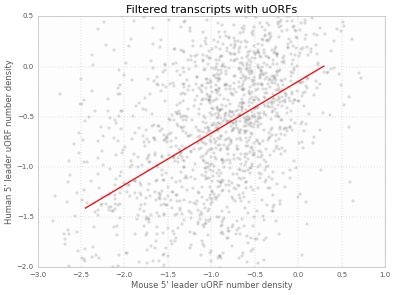

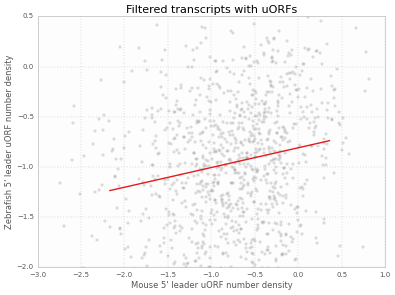

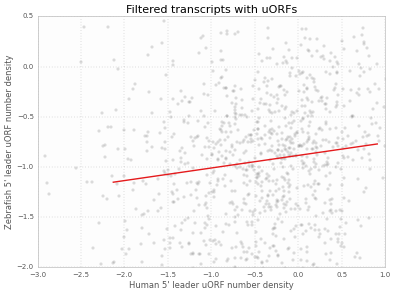

In [21]:
for s, pair in zip(ss, pairs):
    s1, s2 = pair["s1"], pair["s2"]
    set_filter = (s[s1]["num_uORFs"] > 0) & (s[s2]["num_uORFs"] > 0)
    data = clean(s.minor_xs("UTR5_density")[set_filter].applymap(log10))
    
    scatter_linear_trend(data[s1], data[s2],
                         species_label[s1] + " 5' leader uORF number density",
                         species_label[s2] + " 5' leader uORF number density")
    plt.xlim(-3, 1)
    plt.ylim(-2, 0.5)
    plt.title("Filtered transcripts with uORFs")

In [22]:
parameters = ["CDS_TE", "UTR5_TE", "UTR5_repress",
              "CDS_density", "UTR5_density", "Gene_Expression_FPKM",
              "UTR5_length", "UTR5_mean_ssefe_35", "CDS_mean_ssefe_35",
              "CDS_wrent_score", "CDS_sec_struct_EFE_R"]
para_labels = ["CDS TE", "5' Leader TE", "(5' Leader TE / CDS TE)",
               "CDS RP read density", "5' leader RP read density", "Transcript expression",
               "5' leader length", "5' leader mean sec struct EFE", "CDS mean sec struct EFE",
               "CDS WRENT score", "CDS start sec struct EFE right"]
para_is_logs = [True, True, True,
                True, True, True,
                True, False, False,
                False, False]

In [23]:
s_limitss = [[((-2, -0.5), (-3, 0)), ((-3, -0.5), (-3, 0)), ((-1.5, 0.5), (-1.2, 1.2)),
              ((-2, 1.5), (-2.5, 1.5)), ((-2.5, 0.5), (-2, 1)), ((-0.5, 2), (-0.5, 3)),
              ((1.6, 3), (1.6, 3)), ((-15, -4), (-15, -4)), ((-9, -4), (-10, -3)),
              ((-4, 6), (-4, 6)), ((-16, 0), (-16, 0))],
             [((-2, -0.5), (-2.8, -1.2)), ((-3, -0.8), (-3.75, -1)), ((-2, 0.5), (-2, 1)),
               ((-1.4, 1.4), (-2.5, 1)), ((-2, 0.8), (-2.5, 0.3)), ((0, 2.5), (0, 2.5)),
               ((1.4, 3), (1.7, 2.8)), ((-14, -4), (-7, -2)), ((-9, -3), (-7.5, -4)),
               ((-3, 6), (-12, 6)), ((-13, 0), (-13, 0))],
             [((-2.5, -0.3), (-2.5, -1.2)), ((-3.2, -0.2), (-4, -1)), ((-1.5, 1.5), (-2, 1)),
              ((-2, 2), (-2.5, 1.5)), ((-2, 1.5), (-2.5, 0.5)), ((0, 3), (0, 3)),
              ((1.6, 3.2), (1.7, 2.9)), ((-14, -4), (-7, -2)), ((-9, -3), (-7, -4)),
              ((-2, 5), (-12, 5)), ((-15, 0), (-12, 0))]]

**Fig 4a-b, Supp Fig 9**: Conservation of TE, 5' leader repressiveness amongst vertebrate orthologous transcripts, and how that varies by the number of uORFs. Translation over CDSes and 5' leaders is generally conserved between mammals, and covaries by the number of uORFs in a transcript.

Mouse vs Human

c:\Anaconda2\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


CDS TE 5' Leader TE (5' Leader TE / CDS TE)  \
all filtered transcripts  0.494***     0.358***                0.515***   
without uORFs             0.495***     0.423***                0.463***   
with 1-2 uORFs            0.496***     0.325***                0.421***   
with 3+ uORFs             0.382***     0.427***                0.653***   

                         CDS RP read density 5' leader RP read density  \
all filtered transcripts            0.727***                  0.442***   
without uORFs                       0.691***                  0.459***   
with 1-2 uORFs                      0.665***                  0.483***   
with 3+ uORFs                       0.682***                  0.484***   

                         Transcript expression     n  
all filtered transcripts                0.6***  3538  
without uORFs                         0.591***  1002  
with 1-2 uORFs                        0.559***   734  
with 3+ uORFs                         0.609***   403

\*: p < 0.05; \*\*: p < 0.01; \*\*\*: p < 0.001

Mouse vs Zebrafish

CDS TE 5' Leader TE (5' Leader TE / CDS TE)  \
all filtered transcripts  0.235***     0.128***                0.286***   
without uORFs             0.216***       0.135*                  0.129*   
with 1-2 uORFs            0.202***       0.0901                0.236***   
with 3+ uORFs             0.315***      0.197**                0.356***   

                         CDS RP read density 5' leader RP read density  \
all filtered transcripts             0.57***                  0.177***   
without uORFs                       0.478***                  0.275***   
with 1-2 uORFs                      0.536***                    0.127*   
with 3+ uORFs                       0.439***                  0.233***   

                         Transcript expression     n  
all filtered transcripts              0.485***  2220  
without uORFs                         0.427***   248  
with 1-2 uORFs                        0.437***   320  
with 3+ uORFs                         0.398***   240

\*: p < 0.05; \*\*: p < 0.01; \*\*\*: p < 0.001

Human vs Zebrafish

CDS TE 5' Leader TE (5' Leader TE / CDS TE)  \
all filtered transcripts  0.231***      0.11***                0.307***   
without uORFs              -0.0142        0.045                0.221***   
with 1-2 uORFs             0.162**       0.0361                0.216***   
with 3+ uORFs             0.275***        0.115                0.315***   

                         CDS RP read density 5' leader RP read density  \
all filtered transcripts            0.526***                  0.148***   
without uORFs                       0.351***                   0.189**   
with 1-2 uORFs                      0.538***                     0.107   
with 3+ uORFs                       0.367***                     0.119   

                         Transcript expression     n  
all filtered transcripts              0.419***  2077  
without uORFs                         0.415***   220  
with 1-2 uORFs                        0.386***   305  
with 3+ uORFs                          0.208**   243

\*: p < 0.05; \*\*: p < 0.01; \*\*\*: p < 0.001

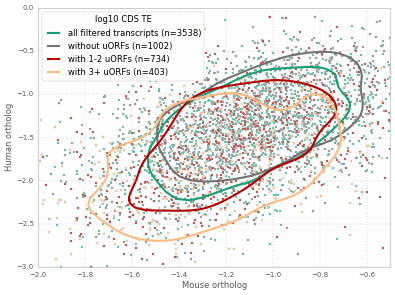

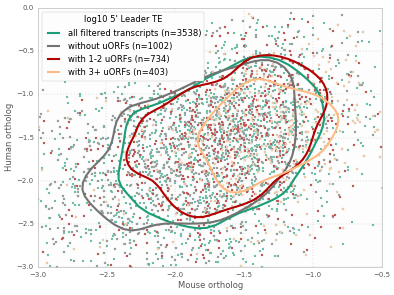

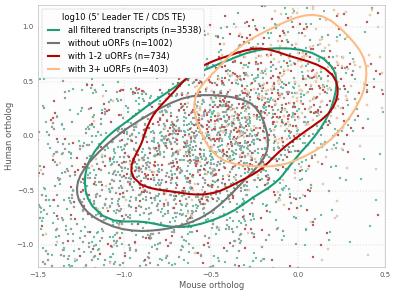

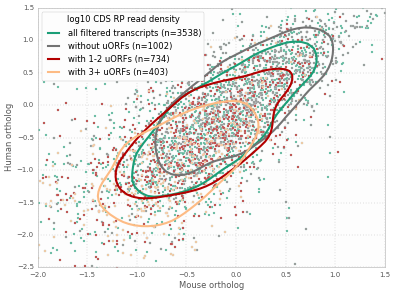

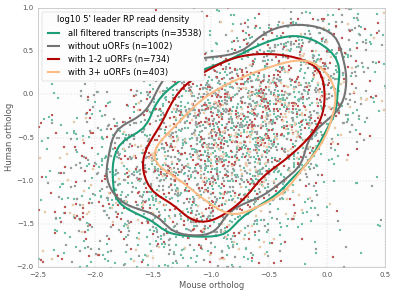

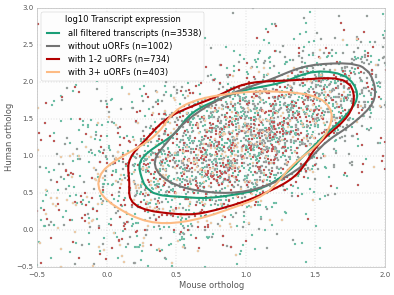

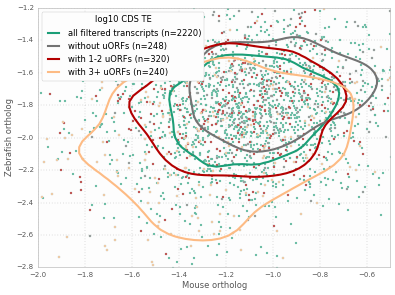

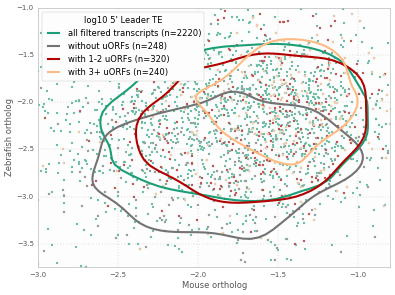

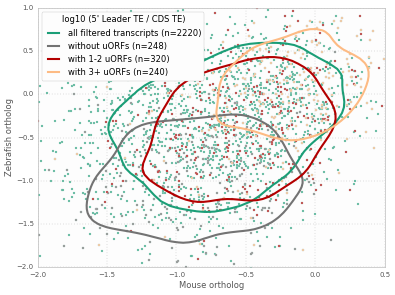

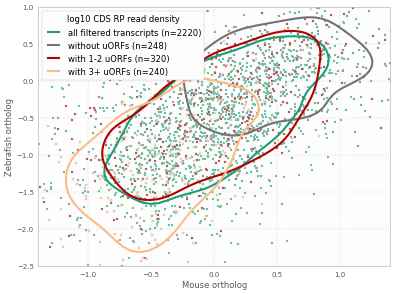

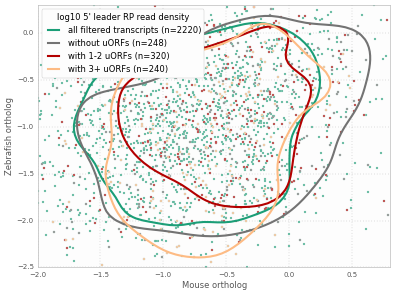

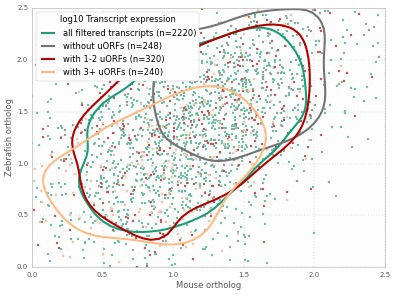

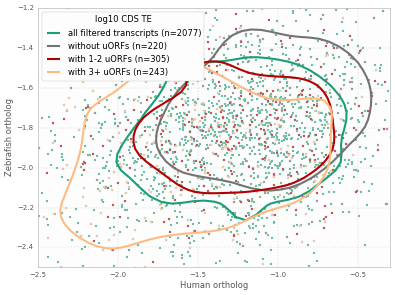

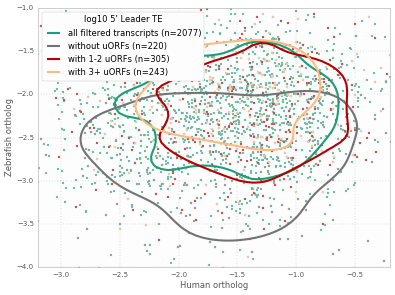

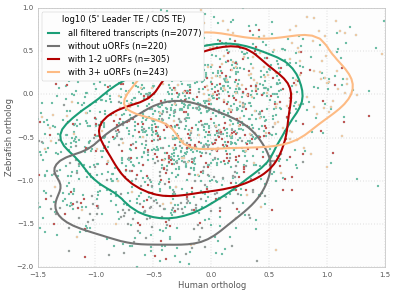

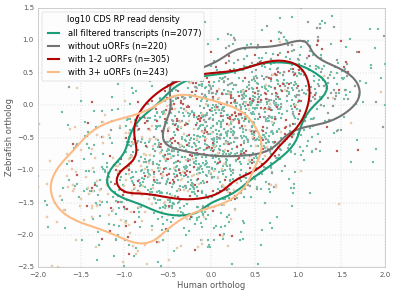

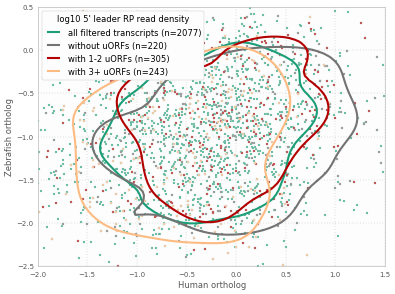

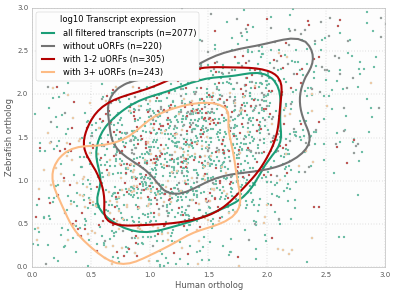

In [24]:
conserve_plot_subset_by_num_uORF(ss, pairs, zip(*zip(*s_limitss)[:6]),
                                 parameters[:6], para_labels[:6], para_is_logs[:6], species_label)

**Fig 4c-f**: Conservation of transcript sequence features amongst vertebrate transcripts. Selected sequence features that affect TE are also generally conserved between mammals; while sequence features in the 5' leader (Fig 4c-d) covary by the number of uORFs in the transcript, conservation of sequence features in the CDS are largely independent of number of uORFs (Fig 4e-f)

Mouse vs Human

5' leader length 5' leader mean sec struct EFE  \
all filtered transcripts         0.452***                      0.541***   
without uORFs                    0.532***                      0.575***   
with 1-2 uORFs                    0.57***                      0.626***   
with 3+ uORFs                    0.416***                        0.6***   

                         CDS mean sec struct EFE CDS WRENT score  \
all filtered transcripts                0.916***        0.652***   
without uORFs                           0.921***        0.675***   
with 1-2 uORFs                          0.925***        0.734***   
with 3+ uORFs                            0.93***        0.628***   

                         CDS start sec struct EFE right     n  
all filtered transcripts                       0.692***  3538  
without uORFs                                  0.709***  1002  
with 1-2 uORFs                                 0.721***   734  
with 3+ uORFs                                  0.681***   403

\*: p < 0.05; \*\*: p < 0.01; \*\*\*: p < 0.001

Mouse vs Zebrafish

5' leader length 5' leader mean sec struct EFE  \
all filtered transcripts         0.312***                     0.0925***   
without uORFs                    0.348***                       0.167**   
with 1-2 uORFs                   0.309***                        0.118*   
with 3+ uORFs                    0.309***                         0.112   

                         CDS mean sec struct EFE CDS WRENT score  \
all filtered transcripts                 0.34***         0.26***   
without uORFs                           0.392***        0.339***   
with 1-2 uORFs                          0.354***          0.17**   
with 3+ uORFs                           0.223***        0.247***   

                         CDS start sec struct EFE right     n  
all filtered transcripts                         0.2***  2220  
without uORFs                                   0.178**   248  
with 1-2 uORFs                                  0.153**   320  
with 3+ uORFs                                    0.138*   240

\*: p < 0.05; \*\*: p < 0.01; \*\*\*: p < 0.001

Human vs Zebrafish

5' leader length 5' leader mean sec struct EFE  \
all filtered transcripts         0.198***                        0.0423   
without uORFs                    0.253***                         0.121   
with 1-2 uORFs                    0.155**                       -0.0557   
with 3+ uORFs                     0.166**                         0.102   

                         CDS mean sec struct EFE CDS WRENT score  \
all filtered transcripts                0.268***        0.228***   
without uORFs                           0.332***          0.153*   
with 1-2 uORFs                          0.297***          0.0817   
with 3+ uORFs                           0.281***        0.221***   

                         CDS start sec struct EFE right     n  
all filtered transcripts                       0.183***  2077  
without uORFs                                    0.18**   220  
with 1-2 uORFs                                  0.185**   305  
with 3+ uORFs                                     0.117   243

\*: p < 0.05; \*\*: p < 0.01; \*\*\*: p < 0.001

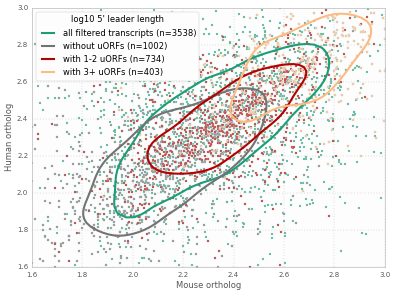

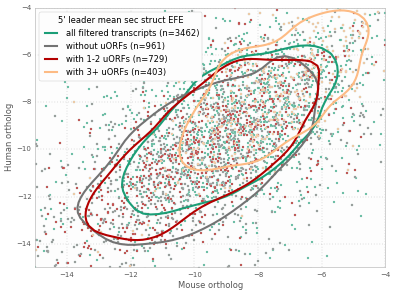

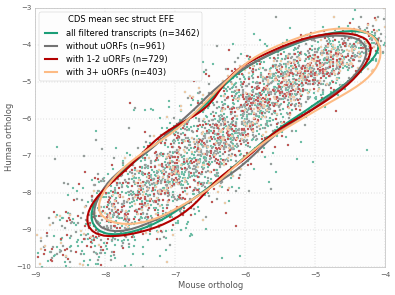

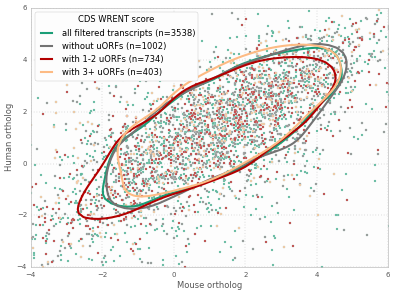

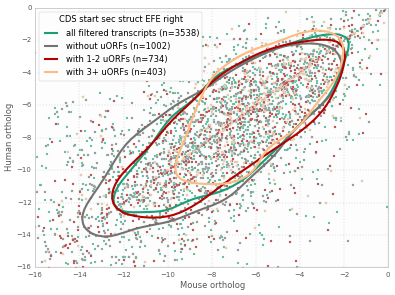

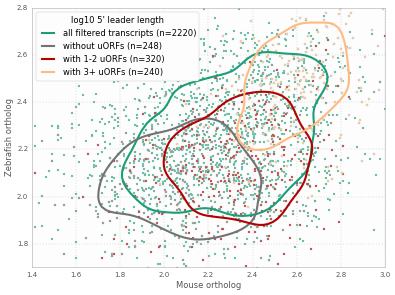

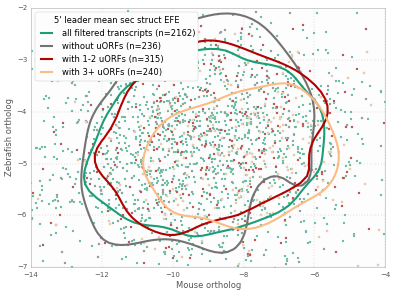

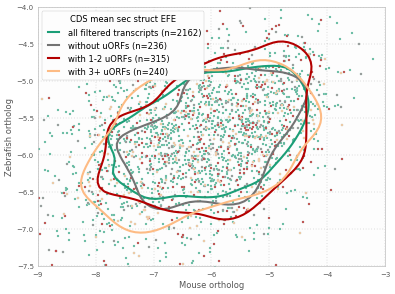

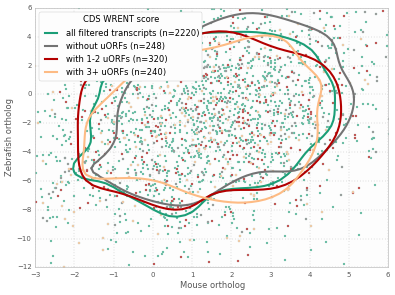

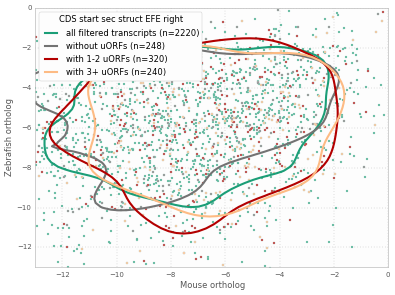

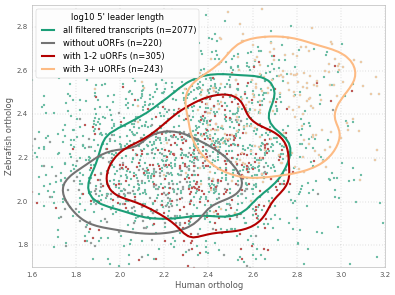

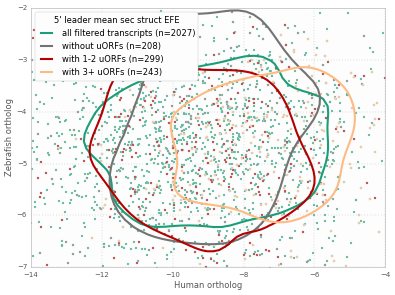

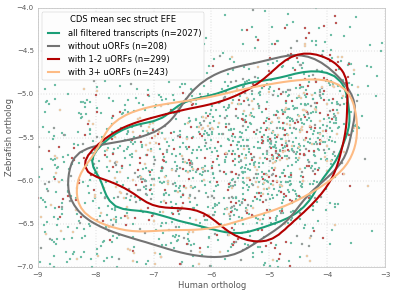

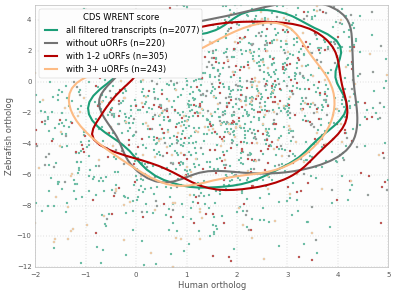

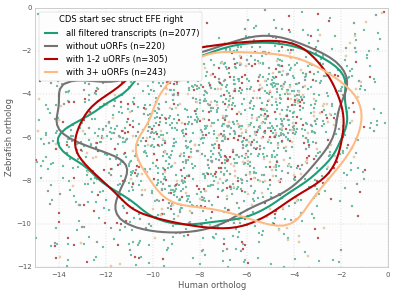

In [25]:
conserve_plot_subset_by_num_uORF(ss, pairs, zip(*zip(*s_limitss)[6:]),
                                 parameters[6:], para_labels[6:], para_is_logs[6:], species_label)

**Supp Fig 11, Supp Tables 5-7**: Conservation of 5' leader and CDS translation amongst all 3 species, subsetted by whether orthologous transcripts have similar numbers of uORFs.

Mouse vs Human

CDS TE 5' Leader TE (5' Leader TE / CDS TE)  \
all filtered transcripts  0.494***     0.358***                0.515***   
similar number of uORFs   0.457***     0.335***                0.503***   
diff number of uORFs      0.516***     0.364***                0.514***   
if uORFs differs          0.408***     0.274***                0.363***   

                         CDS RP read density 5' leader RP read density  \
all filtered transcripts            0.727***                  0.442***   
similar number of uORFs             0.677***                  0.496***   
diff number of uORFs                0.686***                  0.365***   
if uORFs differs                    0.733***                   0.42***   

                         Transcript expression     n  
all filtered transcripts                0.6***  3538  
similar number of uORFs               0.571***  1041  
diff number of uORFs                  0.592***   566  
if uORFs differs                      0.589***   929

\*: p < 0.05; \*\*: p < 0.01; \*\*\*: p < 0.001

Mouse vs Zebrafish

CDS TE 5' Leader TE (5' Leader TE / CDS TE)  \
all filtered transcripts  0.235***     0.128***                0.286***   
similar number of uORFs   0.271***     0.161***                0.322***   
diff number of uORFs      0.165***      0.124**                0.325***   
if uORFs differs          0.152***       0.0434                 0.105**   

                         CDS RP read density 5' leader RP read density  \
all filtered transcripts             0.57***                  0.177***   
similar number of uORFs             0.547***                  0.172***   
diff number of uORFs                0.482***                  0.181***   
if uORFs differs                     0.53***                  0.156***   

                         Transcript expression     n  
all filtered transcripts              0.485***  2220  
similar number of uORFs               0.438***   497  
diff number of uORFs                   0.42***   569  
if uORFs differs                      0.488***   906

\*: p < 0.05; \*\*: p < 0.01; \*\*\*: p < 0.001

Human vs Zebrafish

CDS TE 5' Leader TE (5' Leader TE / CDS TE)  \
all filtered transcripts  0.231***      0.11***                0.307***   
similar number of uORFs   0.242***       0.0525                0.298***   
diff number of uORFs      0.277***     0.183***                0.364***   
if uORFs differs           0.15***     0.0948**                 0.18***   

                         CDS RP read density 5' leader RP read density  \
all filtered transcripts            0.526***                  0.148***   
similar number of uORFs             0.524***                    0.113*   
diff number of uORFs                0.479***                  0.152***   
if uORFs differs                    0.484***                  0.153***   

                         Transcript expression     n  
all filtered transcripts              0.419***  2077  
similar number of uORFs               0.335***   459  
diff number of uORFs                  0.339***   569  
if uORFs differs                      0.446***   829

\*: p < 0.05; \*\*: p < 0.01; \*\*\*: p < 0.001

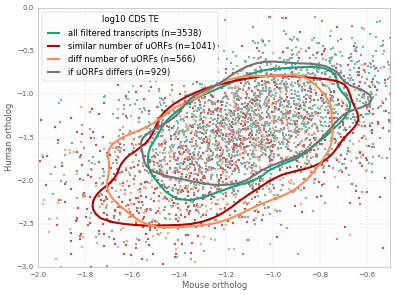

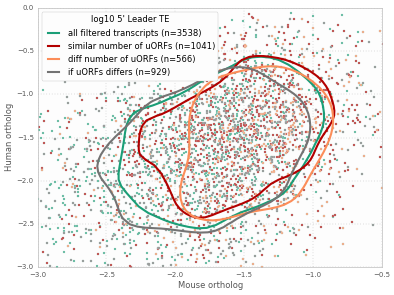

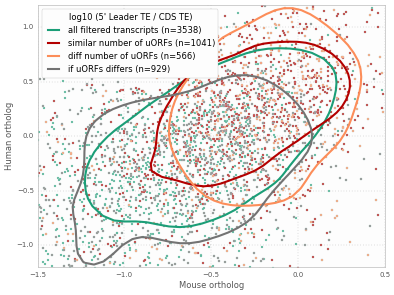

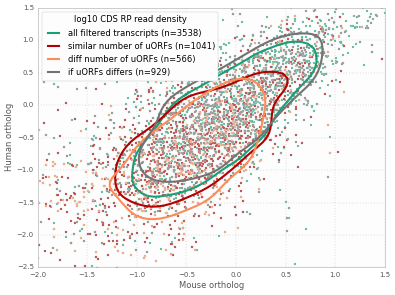

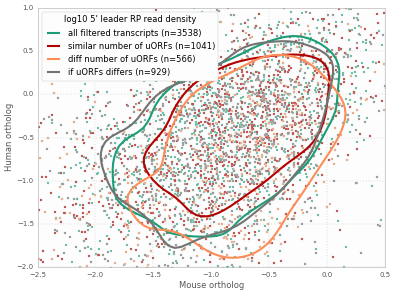

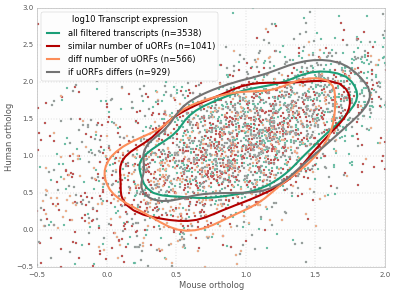

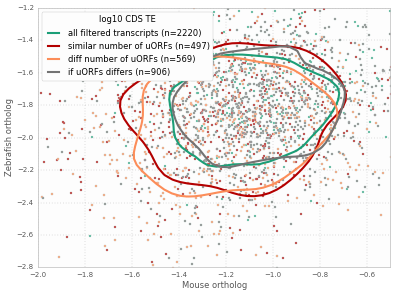

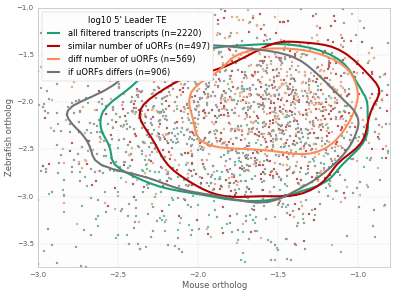

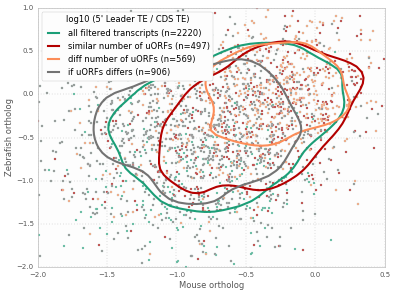

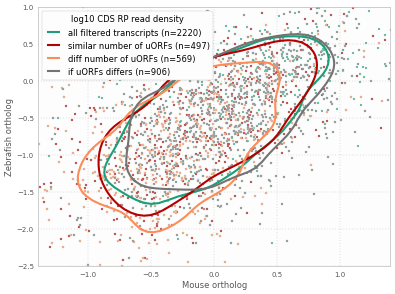

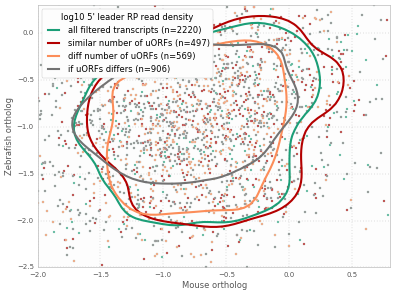

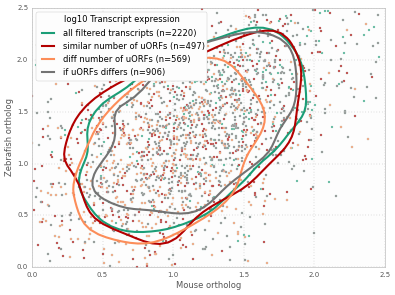

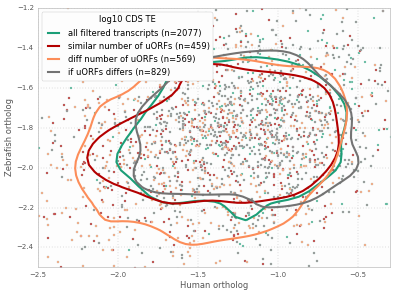

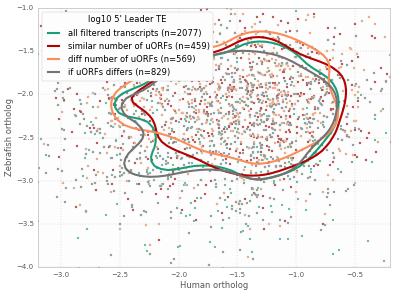

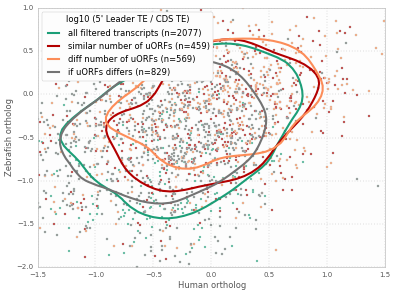

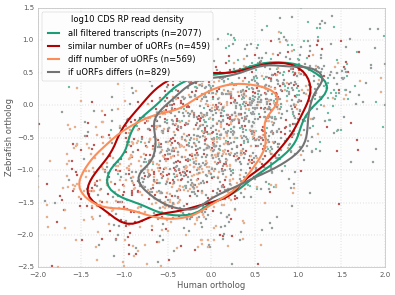

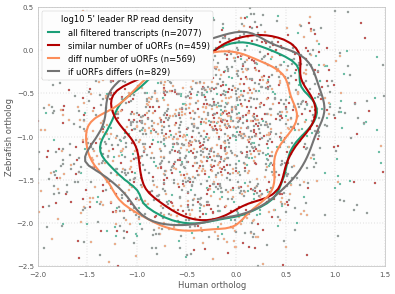

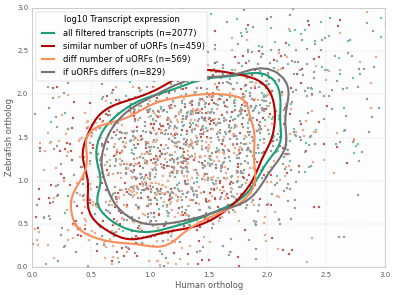

In [26]:
conserve_plot_subset_by_uORF_similarity(ss, pairs, zip(*zip(*s_limitss)[:6]), parameters[:6],
                                        para_labels[:6], para_is_logs[:6], species_label)

Conservation of sequence features in orthologous transcripts amongst species, subsetted by whether uORFs have similar numbers of uORFs.

Mouse vs Human

5' leader length 5' leader mean sec struct EFE  \
all filtered transcripts         0.452***                      0.541***   
similar number of uORFs          0.639***                      0.651***   
diff number of uORFs             0.178***                      0.319***   
if uORFs differs                  -0.0298                       0.35***   

                         CDS mean sec struct EFE CDS WRENT score  \
all filtered transcripts                0.916***        0.652***   
similar number of uORFs                 0.925***        0.712***   
diff number of uORFs                    0.916***        0.617***   
if uORFs differs                        0.899***        0.579***   

                         CDS start sec struct EFE right     n  
all filtered transcripts                       0.692***  3538  
similar number of uORFs                        0.726***  1041  
diff number of uORFs                           0.616***   566  
if uORFs differs                               0.651***   929

\*: p < 0.05; \*\*: p < 0.01; \*\*\*: p < 0.001

Mouse vs Zebrafish

5' leader length 5' leader mean sec struct EFE  \
all filtered transcripts         0.312***                     0.0925***   
similar number of uORFs          0.456***                        0.114*   
diff number of uORFs              0.122**                        0.0399   
if uORFs differs                 0.0963**                       0.105**   

                         CDS mean sec struct EFE CDS WRENT score  \
all filtered transcripts                 0.34***         0.26***   
similar number of uORFs                 0.291***        0.171***   
diff number of uORFs                    0.318***        0.255***   
if uORFs differs                        0.368***        0.277***   

                         CDS start sec struct EFE right     n  
all filtered transcripts                         0.2***  2220  
similar number of uORFs                          0.13**   497  
diff number of uORFs                           0.273***   569  
if uORFs differs                               0.211***   906

\*: p < 0.05; \*\*: p < 0.01; \*\*\*: p < 0.001

Human vs Zebrafish

5' leader length 5' leader mean sec struct EFE  \
all filtered transcripts         0.198***                        0.0423   
similar number of uORFs          0.333***                      -0.00686   
diff number of uORFs               0.0259                        0.0823   
if uORFs differs                  -0.0165                          0.03   

                         CDS mean sec struct EFE CDS WRENT score  \
all filtered transcripts                0.268***        0.228***   
similar number of uORFs                 0.254***          0.106*   
diff number of uORFs                    0.237***         0.28***   
if uORFs differs                        0.281***        0.258***   

                         CDS start sec struct EFE right     n  
all filtered transcripts                       0.183***  2077  
similar number of uORFs                        0.191***   459  
diff number of uORFs                           0.185***   569  
if uORFs differs                                0.18***   829

\*: p < 0.05; \*\*: p < 0.01; \*\*\*: p < 0.001

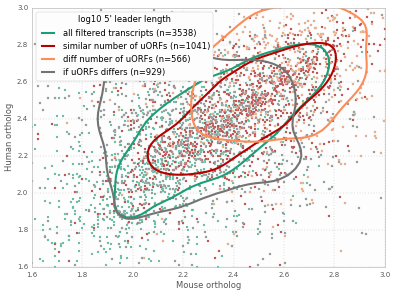

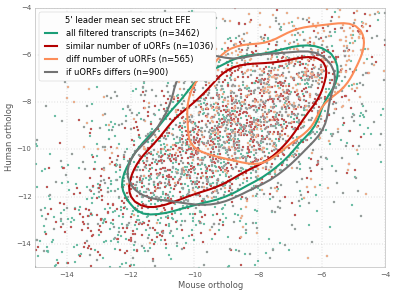

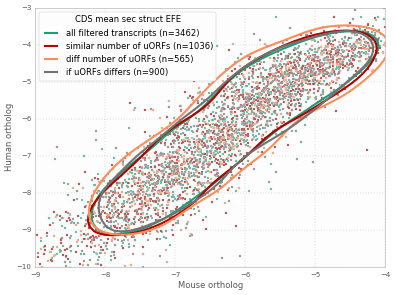

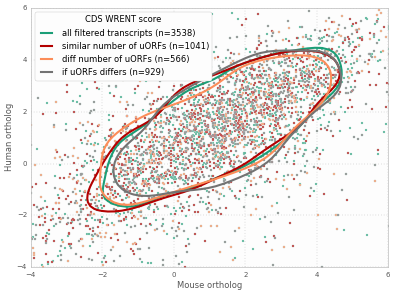

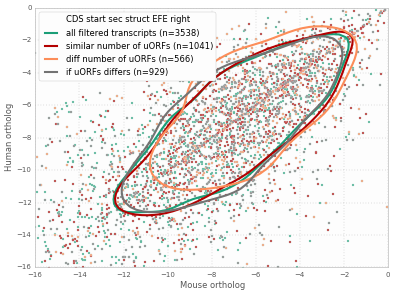

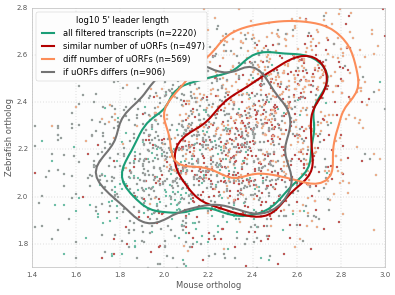

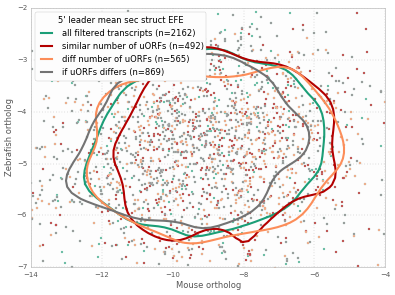

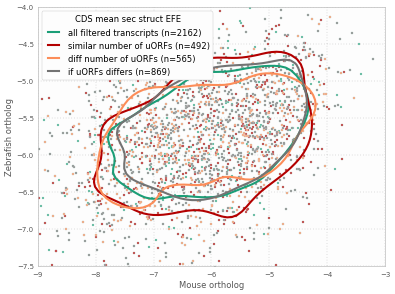

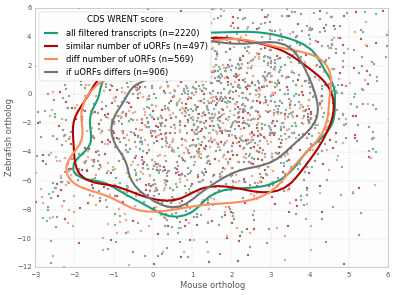

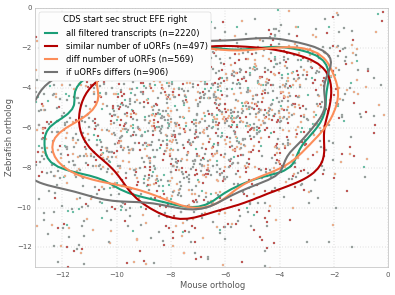

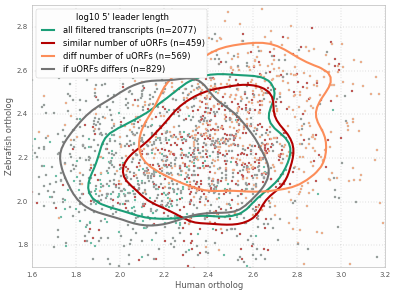

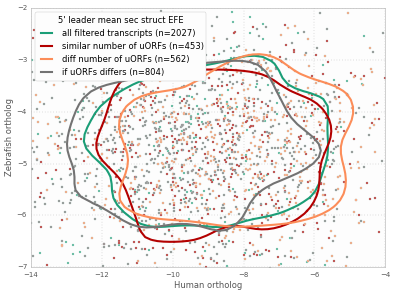

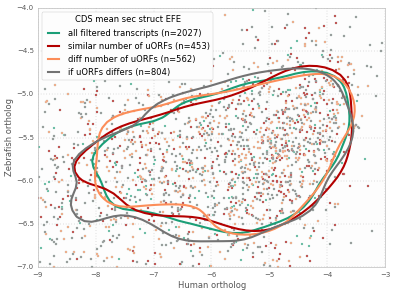

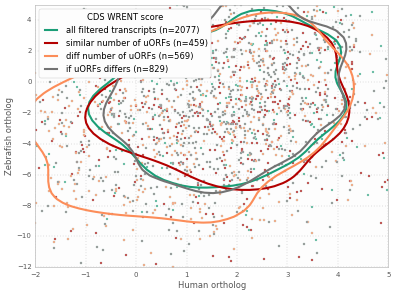

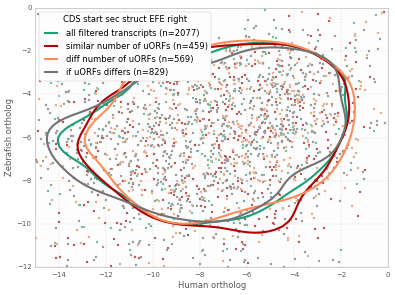

In [27]:
conserve_plot_subset_by_uORF_similarity(ss, pairs, zip(*zip(*s_limitss)[6:]), parameters[6:],
                                        para_labels[6:], para_is_logs[6:], species_label)

**Supp Fig S10:** Contribution of transcript expression and CDS TE to the divergence of total gene translation between various vertebrates

For pairwise comparisons, a subset of transcripts with orthologues present in both species was defined.

Log values of transcript levels, CDS RP read density, CDS TEs, and 5' leader TEs were Z-normalized within this subset of transcripts. Divergence was calculated to be the relative difference between the Z-normalized values between species (could be positive or negative depending on which orthologue had the larger Z-normalized score).

A linear model for the divergence of CDS RP read density was constructed using the divergences of CDS TE, 5' leader TE and transcript expression.

Mouse vs Human (n=3538)

Correlation: 0.9759
p = 0

Relative contribution
Parameter                                  
Transcript expression                0.9041
5' leader TE                        0.01391
CDS TE                               0.5512

Mouse vs Zebrafish (n=2220)

Correlation: 0.9941
p = 0

Relative contribution
Parameter                                  
Transcript expression                0.9163
5' leader TE                        0.01168
CDS TE                               0.4752

Human vs Zebrafish (n=2077)

Correlation: 0.988
p = 0

Relative contribution
Parameter                                  
Transcript expression                0.8442
5' leader TE                        0.01287
CDS TE                                0.543

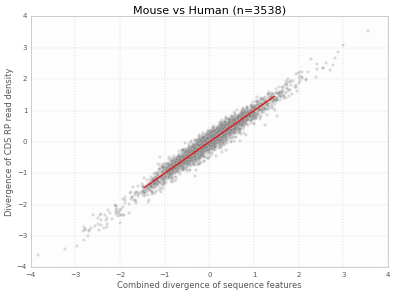

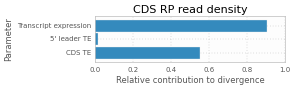

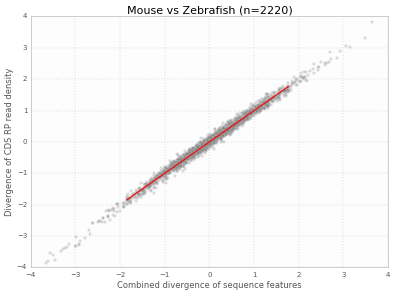

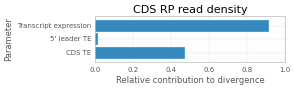

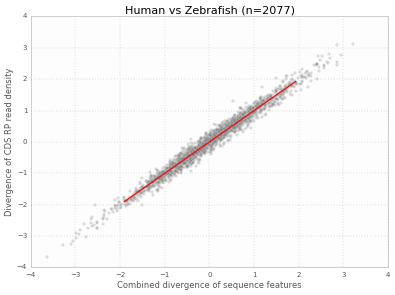

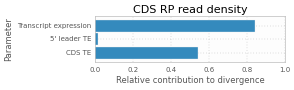

In [28]:
to_regress, to_regress_label = "CDS_density", "CDS RP read density"
regressors, regressor_labels = (["CDS_TE", "UTR5_TE", "Gene_Expression_FPKM"],
                                ["CDS TE", "5' leader TE", "Transcript expression"])
para_is_logs = [True, True, True, True]

ridge_conservation_z(ss, pairs, to_regress, to_regress_label, regressors, regressor_labels, para_is_logs,
                     ((-4, 4), (-4, 4)), (0, 1))

Determining the relative contribution of transcript expression and 5' leader translational efficiency to 5' leader translation.

Mouse vs Human (n=3538)

Correlation: 0.9913
p = 0

Relative contribution
Parameter                                  
Transcript expression                0.9869
5' leader TE                          0.919
CDS TE                             -0.02756

Mouse vs Zebrafish (n=2220)

Correlation: 0.9996
p = 0

Relative contribution
Parameter                                  
Transcript expression                0.9736
5' leader TE                         0.9084
CDS TE                             0.003328

Human vs Zebrafish (n=2077)

Correlation: 0.994
p = 0

Relative contribution
Parameter                                  
Transcript expression                0.9339
5' leader TE                          0.932
CDS TE                             0.007562

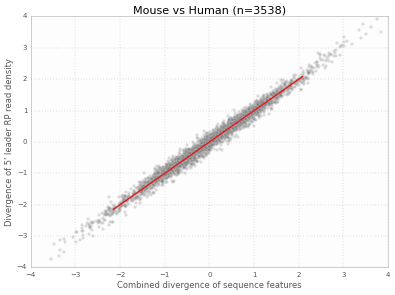

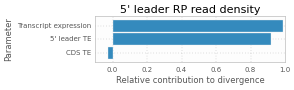

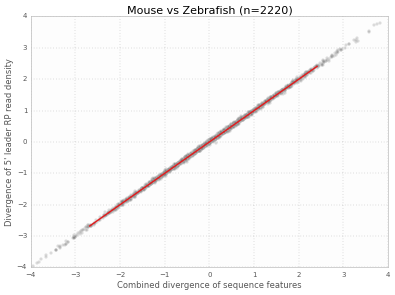

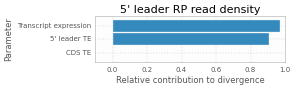

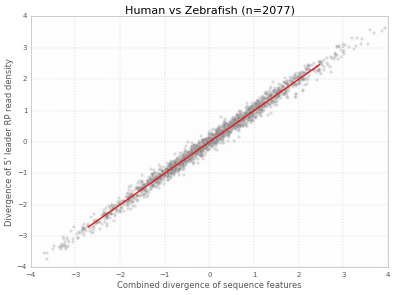

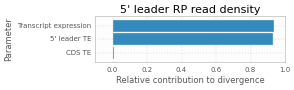

In [29]:
to_regress, to_regress_label = "UTR5_density", "5' leader RP read density"
regressors, regressor_labels = (["CDS_TE", "UTR5_TE", "Gene_Expression_FPKM"],
                                ["CDS TE", "5' leader TE", "Transcript expression"])
para_is_logs = [True, True, True, True]

ridge_conservation_z(ss, pairs, to_regress, to_regress_label, regressors, regressor_labels, para_is_logs,
                     ((-4, 4), (-4, 4)), (-0.1, 1))

### Determining the relative contribution of various sequence features to the divergence of 5' leader repressiveness and CDS TE between species.

Sequence features examined are: 5' leader uORF number density, 5' leader mean sec struct EFE, 5' leader length, CDS mean sec struct EFE, CDS start sec struct EFE right, CDS WRENT score

In [30]:
regressors, regressor_labels = (["UTR5_num_uORFs_density",
                                 "UTR5_mean_ssefe_35",
                                 "UTR5_length",
                                 "CDS_mean_ssefe_35",
                                 "CDS_sec_struct_EFE_R",
                                 "CDS_wrent_score"],
                                ["5' leader uORF number density",
                                 "5' leader mean sec struct EFE",
                                 "5' leader length",
                                 "CDS mean sec struct EFE",
                                 "CDS start sec struct EFE right",
                                 "CDS WRENT score"])
para_is_logs = [True, True, False, True, False, False, False]
color_pos = (C_TLOC["5' UTR"], C_TLOC["CDS start"])
colors = [color_pos[i] for i in (0, 0, 0, 1, 1, 1)]

**Supp Fig 12a-f**: Contribution of sequence features to divergence of 5' leader repressiveness.

c:\Anaconda2\lib\site-packages\pandas\core\frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


Mouse vs Human (n=1601)

Correlation: 0.3368
p = 9.489e-44

Relative contribution
Parameter                                           
CDS WRENT score                            -0.008611
CDS start sec struct EFE right              0.005173
CDS mean sec struct EFE                       0.1544
5' leader length                             -0.3531
5' leader mean sec struct EFE                0.05529
5' leader uORF number density              -0.008865

Mouse vs Zebrafish (n=1057)

Correlation: 0.2689
p = 5.728e-19

Relative contribution
Parameter                                           
CDS WRENT score                              0.03015
CDS start sec struct EFE right               0.02153
CDS mean sec struct EFE                      -0.1198
5' leader length                             -0.1112
5' leader mean sec struct EFE                 0.1005
5' leader uORF number density                 0.1243

Human vs Zebrafish (n=1015)

Correlation: 0.2911
p = 2.821e-21

Relative contribution
Parameter                                           
CDS WRENT score                              0.04796
CDS start sec struct EFE right                0.0966
CDS mean sec struct EFE                     -0.03645
5' leader length                             -0.2451
5' leader mean sec struct EFE                 0.0257
5' leader uORF number density                0.06915

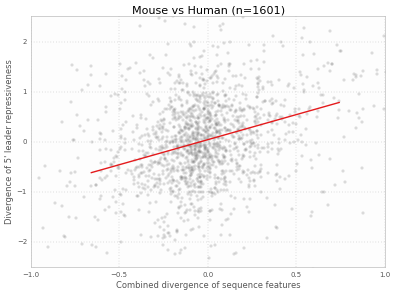

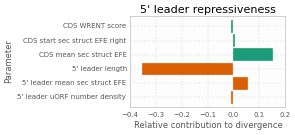

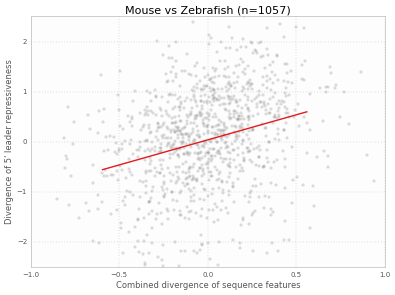

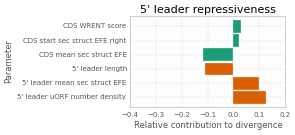

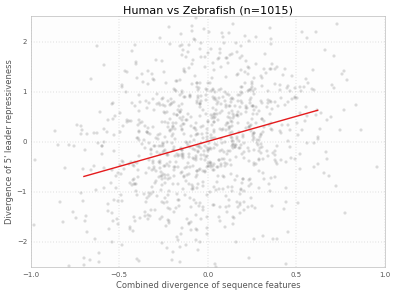

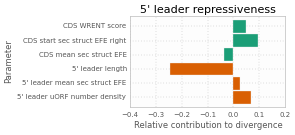

In [31]:
to_regress, to_regress_label = "UTR5_repress", "5' leader repressiveness"

ridge_conservation_z(ss, pairs, to_regress, to_regress_label, regressors, regressor_labels, para_is_logs,
                     ((-1, 1), (-2.5, 2.5)), (-0.4, 0.2), uORF_filter=True, color_coeff=colors)

**Supp Fig 12g-l**: Contribution of sequence features to divergence of CDS TE.

Mouse vs Human (n=1601)

Correlation: 0.1287
p = 2.371e-07

Relative contribution
Parameter                                           
CDS WRENT score                              0.01736
CDS start sec struct EFE right               0.04848
CDS mean sec struct EFE                       0.2054
5' leader length                              -0.061
5' leader mean sec struct EFE                0.07317
5' leader uORF number density               -0.07652

Mouse vs Zebrafish (n=1057)

Correlation: 0.3886
p = 1.933e-39

Relative contribution
Parameter                                           
CDS WRENT score                              0.02885
CDS start sec struct EFE right                0.0636
CDS mean sec struct EFE                       0.3453
5' leader length                            -0.06095
5' leader mean sec struct EFE                 0.1506
5' leader uORF number density                -0.1549

Human vs Zebrafish (n=1015)

Correlation: 0.4074
p = 7.317e-42

Relative contribution
Parameter                                           
CDS WRENT score                             -0.02713
CDS start sec struct EFE right              -0.01428
CDS mean sec struct EFE                       0.3852
5' leader length                            -0.02382
5' leader mean sec struct EFE                  0.115
5' leader uORF number density               -0.07341

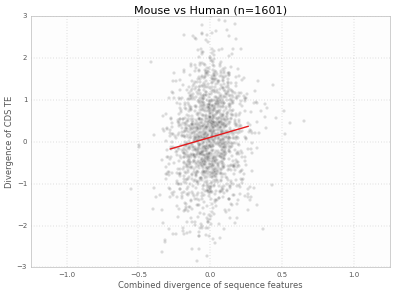

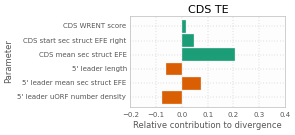

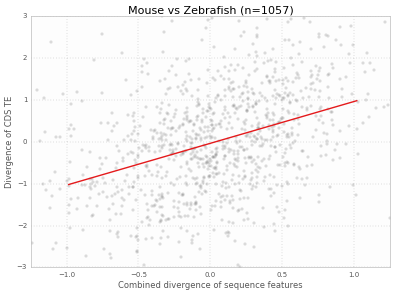

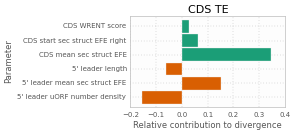

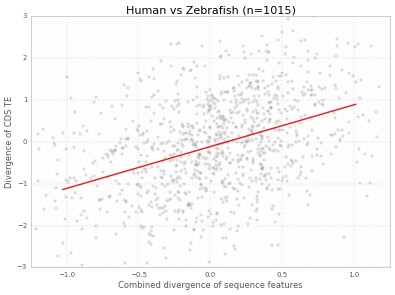

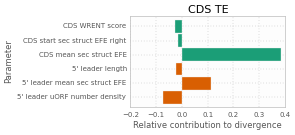

In [32]:
to_regress, to_regress_label = "CDS_TE", "CDS TE"

ridge_conservation_z(ss, pairs, to_regress, to_regress_label, regressors, regressor_labels, para_is_logs,
                     ((-1.25, 1.25), (-3, 3)), (-0.2, 0.4), uORF_filter=True, color_coeff=colors)